In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point,  Polygon, LineString
from shapely import wkt
from cartoframes.auth import Credentials
from cartoframes.data import Dataset
from cartoframes.viz import Map, Layer, basemaps, Layout

from datasets import get_retail_store_minnesota
from utilis import *

from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# **Traveling Salesman Problem**

>"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?".


Travelling Salesman Problem (TSP) aims to find the optimal solution which has the minimal sum of visiting distances and contains only a single tour covering all cities. TSP is a NP-hard problem in Optimization study (specifically in Combinatorial Optimization). And the solutions of TSP have been commonly applied to Vehicle Routing ("What is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers?) and other spatial analytics usecases. 

## **Definition of TSP**

Given Graph $G(V, E)$
- No self-loop in $G$
- $V$: the set of all cities ($i$=1 ... N )
- $E$: the set of roads between cities
- $c_{ij}$: the distance between city $i$ and city $j$
- $\begin{equation}
  x_{ij}=\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ the\ solution\ travels\ from\ city\ i\  to\ city\ j\\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} $
-  $u$:   $u_i$ = $t$,  if city i is visited in step t (i, t = 1, 2, ..., n)


**Target**

$$min\sum_{i=1}^{N}\sum_{j\neq i, j=1}^{N}c_{ij}x_{ij}\\
s.t.\\
\sum_{i=1}^{N}x_{ij}=1 \quad \forall j\in V   \\
\sum_{j=1}^{N}x_{ij}=1 \quad \forall i\in V  \\
u_{i} \in \mathbb{Z}\quad i=1 ... N \\
u_i - u_j + Nx_{ij} \leq N-1 \quad \forall\ i,\ j\in V,\ i\neq j,\ i\neq 1,\ j\neq 1\\
\forall u_{j} \geq 0\\
\forall x_{ij} =0\ or\ 1$$


The restrictions make sure each city is arrived at from exactly one other city and from each city there is a departure to exactly one other city. Also they enforce that there is only a single tour covering all cities, and not two or more disjointed tours that only collectively cover all cities 

## **Algorithms**

In general, there are two types of algorithms to address TSP:
- Exact Algorithms
    - Brute Force $O(n!)$
    - Dynamic Programming $O(n^22^n)$
    - ...
- Approximation Algorithms
    - Christofides Algorithm
    - Simulated Annealing
    - Ant Colony Optimizatiom
    - ...
    
Generally speaking, exact algorithms can reach the best solution but take longer than expected runtime. Considering the time constraint, approximation algorithms are more commonly used even though the solution is not gloabl optimal. The following example shows how to solve TSP. 


## **Example**

We have the location of each Target stores (or any other retailer) in US. Suppose a manager wants to inspect all 73 store in Minnesota, the company's home state, what's the best route with the shortest distance? 


### **Data**

In [2]:
data = get_retail_store_minnesota()
data['store_id'] = data['store_id'].apply(lambda x: str(int(x)))

In [3]:
# lat/lng pairs (e.g.[[47.209549, -93.527193], ...])
latlng = [[store.y, store.x] for store in data['geometry']]
# lng/lat pairs (e.g.[[-93.527193, 47.209549], ...])
lnglat = [[store.x, store.y] for store in data['geometry']]

# id: lat/lng dictionary (e.g.{'100': [47.209549, -93.527193], ...})
latlng_dict = {store[1]['store_id']: [store[1]['geometry'].y, store[1]['geometry'].x] for store in data.iterrows()}
# id: lng/lat dictionary (e.g.{'100': [-93.527193, 47.209549], ...})
lnglat_dict = {store[1]['store_id']: [store[1]['geometry'].x, store[1]['geometry'].y] for store in data.iterrows()}

In [20]:
Map(Layer(data, style={'width': 10}, legend={'title': 'Retail Store Locations'}))

### Method 1: **Christofides Method**


```markdown
1. Create a minimum spanning tree T of G.
2. Let O be the set of vertices with odd degree in T. 
3. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.
4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
5. Form an Eulerian circuit in H.
6. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting).
```

<br/>

**Run `n=100` iterations of Christofides Method, then find the shortest path**, 

The length of the shortest path: 2089803.7008148103 m


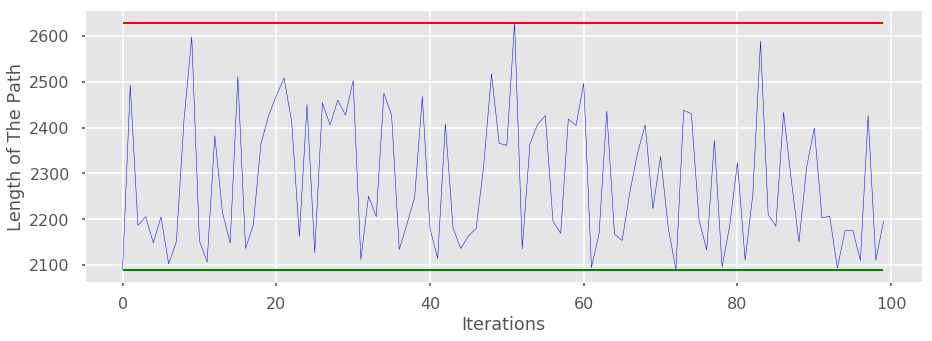

In [33]:
n = 100
tests = [christofides(latlng) for _ in range(n)]
length = [_[6] for _ in tests]  

# the following plot shows length of path of each iteration run. 
f, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(length, color='blue', linewidth=0.5)
ax.hlines(y=min(length), xmin=0, xmax=n-1, color='green', linewidth=2)
ax.hlines(y=max(length), xmin=0, xmax=n-1, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path')

tsp_result = tests[np.argmin(length)]
print(f'The length of the shortest path: {min(length)*1000} m')

<br/>

**The Following part shows how christofides algorithm works step by step**

#### 1. **Complete Graph (G)**

In [22]:
complete_graph = pd.DataFrame([LineString(store) for store in combinations(lnglat, 2)], columns=['geometry'])
map1 = Map(Layer(source = Dataset(complete_graph), 
                 style = {'width': 0.2,
                          'color': 'opacity(red, 0.3)'}),
           basemap = basemaps.voyager)
map1

#### 2. **Minimum Spanning Tree (T)**

In [23]:
minimum_spanning_tree = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[1]], columns=['geometry'])
map2 = Map(layers=[
    Layer(source = Dataset(complete_graph), 
          style = {'width': 0.5,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset(minimum_spanning_tree),
          style = {'width': 3})],
    basemap = basemaps.voyager)
map2

#### 3. **Vertices with odd degree (O)**

In [24]:
vertices_odd_degree = pd.DataFrame([Point(*lnglat[store_id]) for store_id in tsp_result[2]], columns=['geometry'])
map3 = Map(layers=[
    Layer(source = Dataset(complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset(minimum_spanning_tree), 
          style = {'width': 3}),
    Layer(source = Dataset(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.voyager)
map3

#### 4. **Form the subgraph G' of G using only the vertices of O (G')**

In [25]:
sub_complete_graph = pd.DataFrame([LineString(pair) for pair in combinations([list(lnglat)[i] for i in tsp_result[2]], 2)], columns=['geometry'])
map4 = Map(layers=[
    Layer(source = Dataset(sub_complete_graph), 
          style = {'width': 0.8,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.voyager)
map4

#### 5. **Minimum-Weight (perfect) matching M From G' (M)**

In [26]:
min_weight_perfect_matching = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[3]], columns=['geometry'])
map5 = Map(layers=[
    Layer(source = Dataset(sub_complete_graph), 
          style = {'width': 0.7,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset(minimum_spanning_tree), 
          style = {'width': 3,
                   'color': 'opacity(#46aea0, 0.2)'}),
    Layer(source = Dataset(min_weight_perfect_matching), 
          style = {'width': 3, 
                   'color': 'green'}),
    Layer(source = Dataset(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    viewport = {'zoom': 8.21, 'lat': 44.967879, 'lng': -93.365291},
    basemap = basemaps.voyager)
map5

#### 6. **Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H)**

In [27]:
united_eulerian_multigraph = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[4]], columns=['geometry'])
map6 = Map(layers=[
    Layer(source = Dataset(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset(united_eulerian_multigraph), 
          style = {'width': 3, 
                   'color': 'darkgreen'}),
    Layer(source = Dataset(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.voyager)
map6

#### 7. **Euler Tour (E)**

In [28]:
euler_tour = pd.DataFrame([LineString((lnglat[tsp_result[5][i-1]], lnglat[tsp_result[5][i]])) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour['order'] = euler_tour.index + 1
euler_tour_origin = pd.DataFrame([Point(lnglat[tsp_result[5][i-1]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_origin['order'] = euler_tour_origin.index + 1
euler_tour_dst = pd.DataFrame([Point(lnglat[tsp_result[5][i]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_dst['order'] = euler_tour_dst.index + 1

map7 = Map(layers=[
    Layer(source = Dataset(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset(united_eulerian_multigraph), 
          style = {'width': 3, 
                   'color': 'opacity(darkgreen, 0.1)'}),
    Layer(source = Dataset(minimum_spanning_tree), 
          style = {'width': 3,
                   'color': 'opacity(#46aea0, 0.1)'}),
    Layer(source = Dataset(euler_tour), 
          style = {'width': 3,
                   'color': 'opacity(orange, 0.8)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),
    Layer(source = Dataset(euler_tour_origin), 
          style = {'width': 8,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(euler_tour_dst), 
          style = {'width': 8,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'opacity(yellow, 0.1)'})],
    basemap = basemaps.voyager)
map7

#### 8. **Shortcutting**

In [29]:
shortcutting = pd.DataFrame([LineString((lnglat[tsp_result[7][i-1]], lnglat[tsp_result[7][i]])) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting['order'] = shortcutting.index + 1
shortcutting_origin = pd.DataFrame([Point(lnglat[tsp_result[7][i-1]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting_origin['order'] = shortcutting_origin.index + 1
shortcutting_dst = pd.DataFrame([Point(lnglat[tsp_result[7][i]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting_dst['order'] = shortcutting_dst.index + 1

map8 = Map(layers=[
    Layer(source = Dataset(vertices_odd_degree), 
          style = {'width': 1, 
                   'color': 'opacity(yellow, 0.1)'}),
    Layer(source = Dataset(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset(united_eulerian_multigraph), 
          style = {'width': 1, 
                   'color': 'opacity(darkgreen, 0.1)'}),
    Layer(source = Dataset(minimum_spanning_tree), 
          style = {'width': 1,
                   'color': 'opacity(#46aea0, 0.1)'}),
    Layer(source = Dataset(euler_tour), 
          style = {'width': 1,
                   'color': 'opacity(orange, 0.1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),
    Layer(source = Dataset(shortcutting_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(shortcutting_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(shortcutting), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.voyager)
map8

<br/>

In [30]:
Layout([map1, map2, 
        map3, map4,
        map5, map6, 
        map7, map8],
       n_size = 2,
       m_size = 4,
       map_height = 400,
       is_static = False)

### Method 2: **Simulated Annealing**

In [ ]:
# run 
n = 10
output = TravelingSalesmanRun(lnglat_dict, n)
# organize the output
route = result(latlng_dict, output)
# find the shortest route
shortest_route = shortestRoute(route)

[Min] 2006184.4745241895;  [Max] 2084261.1498755063


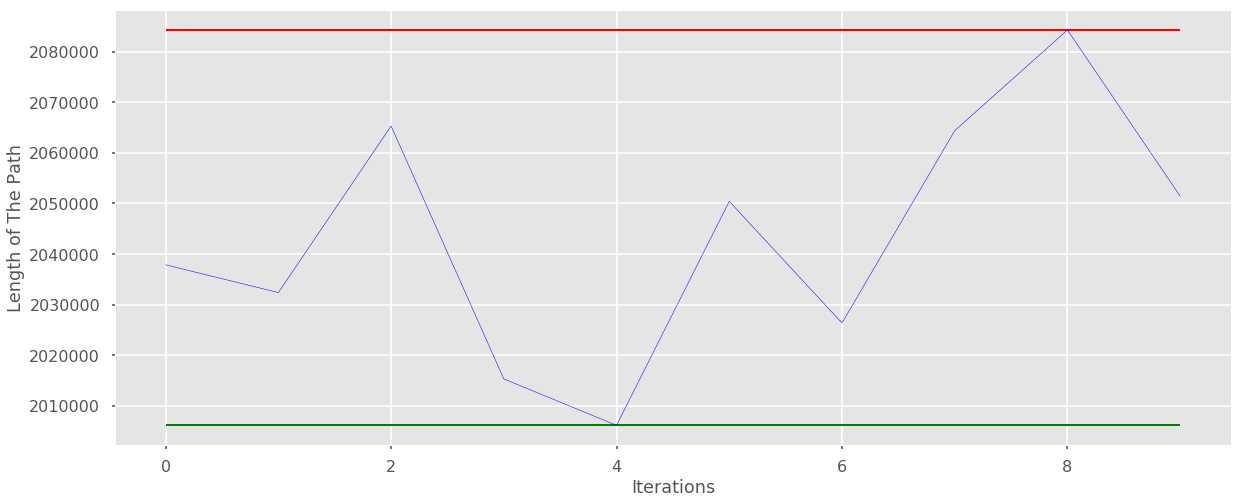

In [16]:
# the following plot shows length of path of each iteration run. 

all_distances = route.drop_duplicates('iteration').sort_values(by='iteration')['distance'].values
random_routes = route.sort_values(by='distance', ascending=False)['iteration'].unique()[:5]
shortest_route = shortest_route.loc[: , ['visitOrder', 'lng', 'lat']]
shortest_route.rename(columns={'visitOrder': 'order'}, inplace=True)

f, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot([_ for _ in all_distances], color='blue', linewidth=0.5)
ax.hlines(y=min([_ for _ in all_distances]), xmin=0, xmax=n-1, color='green', linewidth=2)
ax.hlines(y=max([_ for _ in all_distances]), xmin=0, xmax=n-1, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path');

print(f"[Min] {min([_ for _ in all_distances])};  [Max] {max([_ for _ in all_distances])}")

In [17]:
sa_shortest_route = pd.DataFrame([LineString((shortest_route.values[i-1][1:][::-1], 
                                              shortest_route.values[i][1:][::-1])) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route = sa_shortest_route.append(pd.DataFrame([LineString((shortest_route.values[-1][1:][::-1], shortest_route.values[0][1:][::-1]))], columns=['geometry']))
sa_shortest_route['order'] = sa_shortest_route.index + 1

sa_shortest_route_origin = pd.DataFrame([Point(shortest_route.values[i-1][1:][::-1]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_origin = sa_shortest_route_origin.append(pd.DataFrame([Point(shortest_route.values[-1][1:][::-1])], columns=['geometry']))
sa_shortest_route_origin['order'] = sa_shortest_route_origin.index + 1

sa_shortest_route_dst = pd.DataFrame([Point(shortest_route.values[i][1:][::-1]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_dst = sa_shortest_route_dst.append(pd.DataFrame([Point(shortest_route.values[0][1:][::-1])], columns=['geometry']))
sa_shortest_route_dst['order'] = sa_shortest_route_dst.index + 1

Map(layers=[
    Layer(source = Dataset(sa_shortest_route_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(sa_shortest_route_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(sa_shortest_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.voyager)

<br/>

### Method 3: **Ant Colony Optimization**

In [ ]:
loop = path.copy()
loop.append(loop[0])

ac_shortest_route = pd.DataFrame([LineString((lnglat[loop[i-1]], lnglat[loop[i]])) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route['order'] = ac_shortest_route.index + 1
ac_shortest_route_origin = pd.DataFrame([Point(lnglat[loop[i-1]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_origin['order'] = ac_shortest_route_origin.index + 1
ac_shortest_route_dst = pd.DataFrame([Point(lnglat[loop[i]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_dst['order'] = ac_shortest_route_dst.index + 1

Map(layers=[
    Layer(source = Dataset(ac_shortest_route_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(ac_shortest_route_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(ac_shortest_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.voyager)

In [32]:
loop = path.copy()
loop.append(loop[0])

ac_shortest_route = pd.DataFrame([LineString((lnglat[loop[i-1]], lnglat[loop[i]])) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route['order'] = ac_shortest_route.index + 1
ac_shortest_route_origin = pd.DataFrame([Point(lnglat[loop[i-1]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_origin['order'] = ac_shortest_route_origin.index + 1
ac_shortest_route_dst = pd.DataFrame([Point(lnglat[loop[i]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_dst['order'] = ac_shortest_route_dst.index + 1

Map(layers=[
    Layer(source = Dataset(ac_shortest_route_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(ac_shortest_route_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset(ac_shortest_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.voyager)